In [24]:
import pandas as pd
import numpy as np
import joblib
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
clinical_df = pd.read_csv("../data/processed/train_ready/clinical_df_v1.csv")
clinical_df.sort_values(['timestamp', 'patient_id'], inplace=True)
clinical_df.dropna(inplace=True)

In [25]:
clinical_df.head()

,timestamp,puffs,district,longitude,latitude,station,PM2.5 (µg/m³),NO2 (µg/m³),O3 (µg/m³),patient_id,...,24h_puffs,24h_PM25_avg,24h_NO2_avg,24h_O3_avg,PM25_exceedance,NO2_exceedance,O3_exceedance,hospitalization,gema_risk_score,district_risk
11,2024-01-01 11:00:00,0.0,Horta-Guinardo,2.159675,41.428983,54.0,6.00,9.0,39.0,PAT-0000,...,2.0,7.329167,30.750000,42.416667,0,0,0,0,1.579626,0.170088
8771,2024-01-01 11:00:00,0.0,Gracia,2.156086,41.401973,44.0,8.38,22.0,28.0,PAT-0001,...,0.0,9.696667,27.750000,36.816667,0,0,0,0,0.501747,0.115916
17531,2024-01-01 11:00:00,0.0,Sants-Montjuic,2.132610,41.359666,42.0,8.38,11.0,48.0,PAT-0002,...,1.0,7.944167,26.666667,42.000000,0,0,0,0,0.423715,0.155943
26291,2024-01-01 11:00:00,0.0,Sant Marti,2.189315,41.398256,4.0,8.38,23.0,48.0,PAT-0003,...,1.0,7.944167,33.833333,42.000000,0,0,0,0,0.404947,0.123995
35051,2024-01-01 11:00:00,0.0,Les Corts,2.132044,41.385493,57.0,17.80,11.0,30.0,PAT-0004,...,1.0,15.283333,15.541667,26.233333,1,0,0,0,1.200000,0.151566


<Axes: >

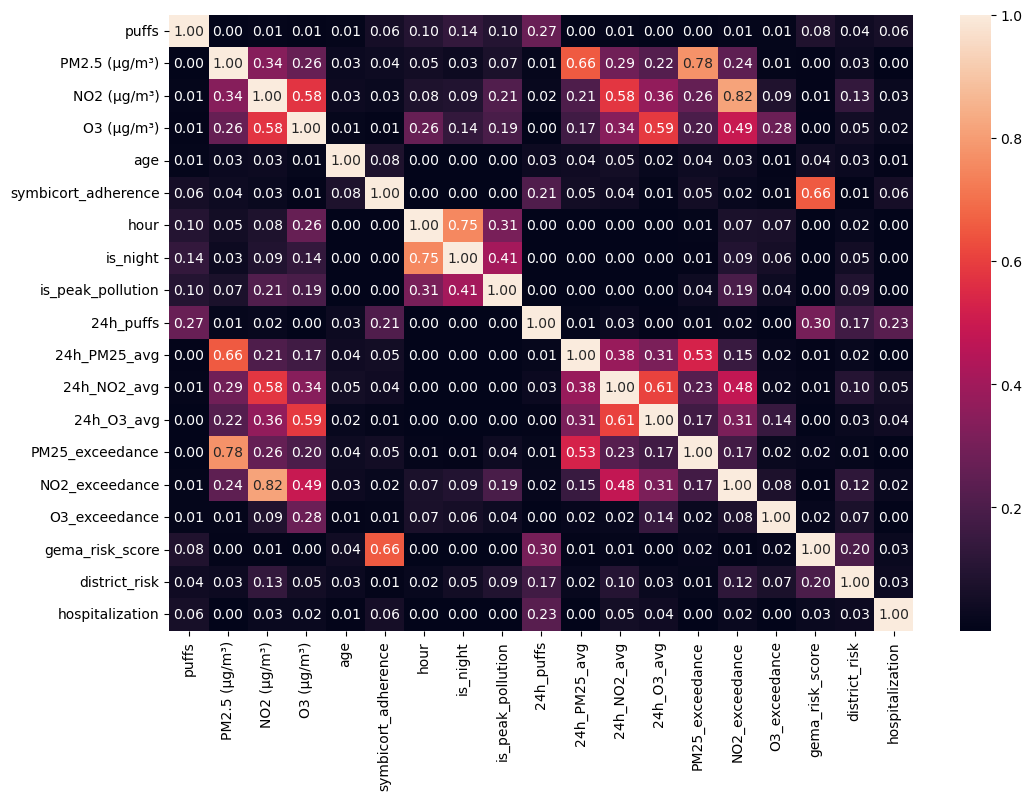

In [27]:
numerical_cols = ['puffs', 'PM2.5 (µg/m³)', 'NO2 (µg/m³)', 'O3 (µg/m³)', 
       'age', 'symbicort_adherence', 'hour', 'is_night', 'is_peak_pollution',
       '24h_puffs', '24h_PM25_avg', '24h_NO2_avg', '24h_O3_avg',
       'PM25_exceedance', 'NO2_exceedance', 'O3_exceedance', 
       'gema_risk_score', 'district_risk', 'hospitalization']

corr_matrix = np.abs(clinical_df[numerical_cols].corr())

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

In [32]:
import pandas as pd
import numpy as np
import joblib
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import json

# Load and prepare data
clinical_df = pd.read_csv("../data/processed/train_ready/clinical_df_v1.csv")
clinical_df.sort_values(['timestamp', 'patient_id'], inplace=True)
clinical_df.dropna(inplace=True)

# Strategic features (removed patient_id)
features = ['PM2.5 (µg/m³)', 'NO2 (µg/m³)', 'O3 (µg/m³)', 
       'age', 'symbicort_adherence', 'hour', 'is_night', 'is_peak_pollution', 
       '24h_PM25_avg', '24h_NO2_avg', '24h_O3_avg',
       'PM25_exceedance', 'NO2_exceedance', 'O3_exceedance', 
       'gema_risk_score', 'district_risk']

target = '24h_puffs'

X = clinical_df[features]
y = clinical_df[target]

# Temporal split (60% train, 20% validation, 20% test)
n = len(X)
train_end = int(n * 0.6)
val_end = train_end + int(n * 0.2)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

# Save datasets to folder
split_dir = "../data/processed/splits"
os.makedirs(split_dir, exist_ok=True)

pd.concat([X_train, y_train], axis=1).to_csv(f"{split_dir}/train_data.csv", index=False)
pd.concat([X_val, y_val], axis=1).to_csv(f"{split_dir}/val_data.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv(f"{split_dir}/test_data.csv", index=False)

# Load model_config
with open("../config/model_config.json", "r") as f:
    params = json.load(f)

# Initialize the model
model = XGBRegressor(**params)

# Train with validation monitoring
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Final evaluation on test set
y_pred = model.predict(X_test)
print(f"\nTest Performance:")
print(f"- MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"- R²: {r2_score(y_test, y_pred):.2f}")

# Clinical utility check
accuracy_within_2 = np.mean(np.abs(y_test - y_pred) <= 2)
print(f"- Predictions within ±2 puffs: {accuracy_within_2:.1%}")

"""
# Save model with timestamp
model_dir = "../model/experiments"
os.makedirs(model_dir, exist_ok=True)
model_path = f"{model_dir}/xgb_{datetime.now().strftime('%Y%m%d-%H%M')}_mae_{mean_absolute_error(y_test, y_pred):.1f}.pkl"
joblib.dump(model, model_path)
print(f"\nModel saved to: {model_path}")
"""

[0]	validation_0-mae:2.07141
[1]	validation_0-mae:2.02613
[2]	validation_0-mae:1.98385
[3]	validation_0-mae:1.95512
[4]	validation_0-mae:1.91698
[5]	validation_0-mae:1.88478
[6]	validation_0-mae:1.85421
[7]	validation_0-mae:1.82760
[8]	validation_0-mae:1.81134
[9]	validation_0-mae:1.79521
[10]	validation_0-mae:1.77359
[11]	validation_0-mae:1.75472
[12]	validation_0-mae:1.73610
[13]	validation_0-mae:1.71881
[14]	validation_0-mae:1.70376
[15]	validation_0-mae:1.69696
[16]	validation_0-mae:1.68233
[17]	validation_0-mae:1.67147
[18]	validation_0-mae:1.65877
[19]	validation_0-mae:1.64716
[20]	validation_0-mae:1.63798
[21]	validation_0-mae:1.63240
[22]	validation_0-mae:1.62458
[23]	validation_0-mae:1.61781
[24]	validation_0-mae:1.61495
[25]	validation_0-mae:1.60844
[26]	validation_0-mae:1.60208
[27]	validation_0-mae:1.59880
[28]	validation_0-mae:1.59307
[29]	validation_0-mae:1.58772
[30]	validation_0-mae:1.58538
[31]	validation_0-mae:1.58105
[32]	validation_0-mae:1.57709
[33]	validation_0-ma

'\n# Save model with timestamp\nmodel_dir = "../model/experiments"\nos.makedirs(model_dir, exist_ok=True)\nmodel_path = f"{model_dir}/xgb_{datetime.now().strftime(\'%Y%m%d-%H%M\')}_mae_{mean_absolute_error(y_test, y_pred):.1f}.pkl"\njoblib.dump(model, model_path)\nprint(f"\nModel saved to: {model_path}")\n'

In [44]:
# Clinical evaluation
preds = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, preds):.2f} puffs/24h')
print(f'R²: {r2_score(y_test, preds):.2f}')

# Feature importance for decision-making
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

MAE: 1.49 puffs/24h
R²: 0.49


/tmp/ipykernel_31656/313985121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')


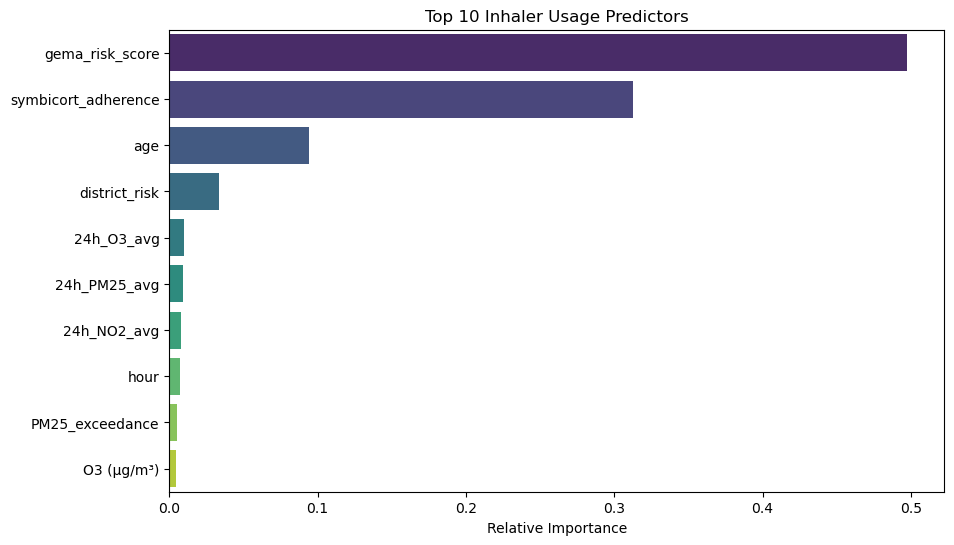

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Inhaler Usage Predictors')
plt.xlabel('Relative Importance')
plt.ylabel('')
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()